#   Face detection 

<centre>![do something](https://miro.medium.com/max/1024/1*I8XBP5TQrAFCBW_jQZBbZw.jpeg)</centre>

<br/>
in computer vision is the field where human try to teach computers how to understand and get information from images by using many techniques of deep learning, there are a lot of implimentation for this, like object detection, object classification, text detection....etc

**object detection** is one of the hardest problems, it consiste of 2 steps, detecting the object in other word, try to detect the location of objects in an image that contains a lot of objects, and try to classify this detected obeject, many algorthim were detected for this, like **R-CNN** and **Fast R-CNN** which is an improved version of the first one, but it still slow and can't really be used in realy time detection then they created **YOLO** (You Only Look Once) algorith that overperform the R-CNN  and many other algorithms.

in our problem of face detection it's the same logic that can be used to solve it, one network or algorithm to detect the face area and another network to detect if it's a face or not. 

we won't go till the real time detection, but we will train our own classifier, then try to create a **window sliding** algorithm that can detect the face's area.


so in the cell below you can find the different secions of our notebook

1. **[Load the data](#load)**
2. **[visualization of our data](#print)**
3. **[model and training tools](#model)**
4. **[Window SLider](#window)**
5. **[YOLO V3](#yolo)**

# <a id='load'>loading the data</a>

the first step of any learning algorithm is to load your data. and print some simples so you can have an idea about it, and know what you will  do next (data augmentation,cleaning...etc) or just move to learning step. in our loading data algorithm we will make it so clean by using only dicts so when we want to change anything it would be so simple

but after that we will import some useful libraries

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import os

# create transforms in this case we will applay Random rotation on our data, then we resize our images to 64 * 64 and all that we will be transferred to a tansors than normalized
images_transform = {'train':transforms.Compose([ transforms.RandomRotation(20),
                                        transforms.Resize((64,64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]),
                    'test':transforms.Compose([ transforms.Resize((64,64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
                   
                   }

# we save the data dirs in the a dict to use it after

images_dir = { 
                'train': '../input/somefaces/data/train_images',
                'test': '../input/somefaces/data/test_images'
             }


## we load the data and transform it using our transform
images_data = { 'train': torchvision.datasets.ImageFolder(images_dir['train'],transform=images_transform['train']),
                'test': torchvision.datasets.ImageFolder(images_dir['test'],transform=images_transform['test'])
              }

### in our case i will split the training data into 3 subsets  a train, validation and another test set because i think that the test set that we have is not enough .
# first we calculate the data that we have (we won't have the exact number because we did some data augmentation, but it's okay we don't need to have the exact number)
number_train_data = len(os.listdir('../input/somefaces/data/train_images/1')) + len(os.listdir('../input/somefaces/data/train_images/0')) 
# we create a list of indices 
indices = np.arange(number_train_data)
# we shuffle it
np.random.shuffle(indices)

# we calculate the validationset's size and it will be the same size as the test_2 (2nd version of testset)
valid_size = int(0.25 *  number_train_data)

# we create our laoders 
data_loaders = { 'train': torch.utils.data.DataLoader(images_data['train'],batch_size = 32,sampler=SubsetRandomSampler(indices[2 * valid_size:])),
                 'valid': torch.utils.data.DataLoader(images_data['train'],batch_size = 32,sampler=SubsetRandomSampler(indices[:valid_size])),  
                 'test_1': torch.utils.data.DataLoader(images_data['test'],batch_size = 32,shuffle=True),             
                 'test_2': torch.utils.data.DataLoader(images_data['train'],batch_size = 32,sampler=SubsetRandomSampler(indices[valid_size: 2* valid_size]))
               }

# <a id='print'>visualization of our data</a>

this is an important step of any similar problem, seeing the data (seeing the images, ploting your data if they are numbers, see some correlation tables...etc ) this can give u an idea about what is wrong with your data (if anything is wrong of course), what you should do next what kind of cleaning or augmentation do you need and what is the best algorith to use and many other informations

In [3]:
def visulize(data):
        plt.subplot(1, 3, 1)
        plt.imshow(data[0][0].permute(1,2,0))
        plt.subplot(1,3,2)
        plt.imshow(data[0][2].permute(1,2,0))
        plt.subplot(1,3,3)
        plt.imshow(data[0][3].permute(1,2,0))

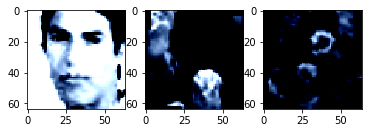

In [4]:
iterate = iter(data_loaders['train'])
visulize(next(iterate))

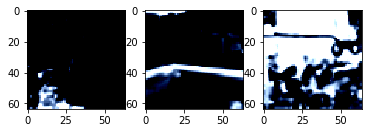

In [5]:
iterate = iter(data_loaders['test_1'])
visulize(next(iterate))

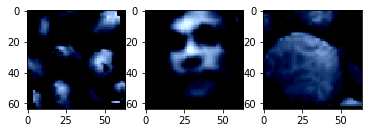

In [6]:
iterate = iter(data_loaders['test_2'])
visulize(next(iterate))

we see that our data looks good (not for human but hoping it's good for computers ;) ), there is a 20 degrees rotation in some images, most of images don't look okay  because of the normalization that we made

now it's time for talking deep learning
so let's creat our model and some function for trianing and testing 

# <a id="model"> model and training tools</a>

so in this part we will try to  build our model, train it and see how well we did, maybe change the model and trian again and so on till we get a model that predict well 

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## ----------------Convolution layer
        self.conv_1 = nn.Conv2d(3,6,kernel_size = 3, stride = 2)
        self.conv_2 = nn.Conv2d(6,6,kernel_size = 3, stride = 2)        
        self.conv_3 = nn.Conv2d(6,3,kernel_size = 3, stride = 2)   
        
        ##---------------- pooling layers
        
        self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # calculate the output from the conv layers
        self.fc_input_size = 3*3*3
        
        ##--------------- fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,2)
        ## create a dropout with p=0.15
        self.dropout = nn.Dropout(p = 0.15)
    

    def forward(self, x):
        # conv 1
        x = self.conv_1(x)
        x = F.relu(x)
        # conv 2
        x = self.conv_2(x)
        x = F.relu(x)
        
        x = self.pooling(x)
        # conv 3
        x = self.conv_3(x)
        x = F.relu(x)
        
        ### transform the output of the last layer to a  vector
        x = x.view(-1,self.fc_input_size)
        
        # fully connnected 1
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        # fully connnected 2
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        
        # output 
        x = self.fc3(x)
        x = F.softmax(x)
        return x

in human logic we train than we test, we lean than we have exams, but in this case we will define a test function first than the training function, because we will need the test function in the training function.

In [8]:
# before we define anything we will let our model know in what device we are working on now, if it's GPU (it will be happy if it is), or a simple poor CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def testing(model = None,testloader = None,criterion = None, print_accuracy = False):
    correct = 0
    total = 0
    loss = 0
    more_statistic = {0:{0:0,1:0},1:{0:0,1:0}}
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            result = model(inputs)
            loss += criterion(result,labels)
            _,predicted = torch.max(result.data, 1)
            for i in range(len(predicted)):
                more_statistic[int(labels[i])][int(predicted[i])] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if print_accuracy:
        print('Accurcy is :: {:.2f}' .format(100 * correct / total))
    return loss.item() , (100 * correct / total),more_statistic

In [10]:
def trianing(epochs = 100,model = None,criterion = None, optimizer = None, train_loader = None,valid_loader = None,saved_file_name = "checkpoint_v5.pth"):
    losses = list()
    min_loss = 1e6
    total = 0
    counter = 0
    for epoch in range(epochs):
        if counter == 30:
            break
        epoch_loss = 0
        for i,data in enumerate(train_loader,1):
           
            
            inputs, labels = data
            
            if epoch == 0:
                total += labels.size(0)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            result = model(inputs)
            loss = criterion(result,labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        losses.append(epoch_loss)
        validation_loss,_,__ = testing(model = model,testloader = valid_loader,criterion = criterion)
        counter += 1
        print('Epoch {}\t train loss :: {:.2f} and the validation loss is ::{:.2f}'.format(epoch, epoch_loss,validation_loss))
        if min_loss > validation_loss:
            counter = 0
            min_loss = validation_loss
            print('#------------------  saving the model in {} epoch with validation loss :: {:.2f}'.format(epoch,validation_loss))
            torch.save(model.state_dict(),saved_file_name)

and here it cames the learning phase, it will take a very long time even on GPU because we have like a really big number of images

In [11]:
import torch.optim as optim
model_v1 = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v1.parameters(),lr = 1e-3)

In [ ]:
# trianing(epochs = 350,
#          model = model_v1,
#          criterion = criterion,
#           optimizer = optimizer, 
#           train_loader = data_loaders['train'],
#           valid_loader = data_loaders['valid'])

now it's time to test our model on the training test, we will start by loading our saved model (in case it change after the last saving time)

In [13]:
model_v1.load_state_dict(torch.load('../input/lastversion/checkpoint_v5.pth',map_location='cpu'))

<All keys matched successfully>

In [14]:
def print_statistics(statistics):
    ### printing
    print("\t Confusion Matrix")
    print('True Positive \t {}'.format(statistics[1][1]))
    print('False Negative\t {}'.format(statistics[0][1]))    
    print('False Positive\t {}'.format(statistics[1][0]))    
    print('True Negative \t {}'.format(statistics[0][0]))
    
    print("\t  Precision and Recall")
    print('Precision  {:.3f}\t'.format(statistics[1][1]/(statistics[1][1] + statistics[1][0])))
    print('Recall     {:.3f}\t'.format(statistics[1][1]/(statistics[1][1] + statistics[0][1])))    

In [15]:
loss,accuracy,statistics = testing(model_v1,data_loaders['test_1'],criterion,True)
print_statistics(statistics)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accurcy is :: 93.92
	 Confusion Matrix
True Positive 	 402
False Negative	 69
False Positive	 395
True Negative 	 6762
	  Precision and Recall
Precision  0.504	
Recall     0.854	


In [16]:
loss,accuracy,statistics = testing(model_v1,data_loaders['test_2'],criterion,True)
print_statistics(statistics)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accurcy is :: 99.05
	 Confusion Matrix
True Positive 	 16167
False Negative	 108
False Positive	 110
True Negative 	 6545
	  Precision and Recall
Precision  0.993	
Recall     0.993	


# <a id="window">Window slider</a>
in this part we will try to detect faces in a picture where there is different faces in a different sizes, we will use a what we call a widnow slider, it's a window 64*64 but in different sizes of the same image.


* in the first slinding operation we will use an image of a closer size to the original one
* in the second operation we will reduce the size of oue image by 20% if it's prevuois size
* in the 3ed operation we will repeat the 2nd operation

after each operation we collect these sub imgaes and we try to predict if the probabilty of the existing of a face by using our model.****

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# read the image and define the stepSize and window size 
# (width,height)


def window_sliding(pic_name = "../input/justpeople/happy_young_people2.jpg",window_size =(64,64),step_size = 5,iterations = 3, pic_reducing = 0.3):
    model_v1.to('cpu')
    image = cv2.imread(pic_name) # your image path
    
    h = (image.shape[0] // window_size[0])
    w = (image.shape[1] // window_size[1])
    
    windows =list()
    
    for i in range(iterations):
        
        h = int(h * (1 - i * pic_reducing )) 
        w = int(w * (1 - i * pic_reducing ))
        temp = cv2.resize(image, (w * window_size[1],h * window_size[0]), interpolation = cv2.INTER_AREA)
        for x in range(0, image.shape[1]  , step_size):
            for y in range(0, image.shape[0] , step_size):
                window ={"image":temp[x:x + window_size[1], y:y + window_size[0], :],
                         "location": ([x,x + window_size[1]], [y,y + window_size[0]]),
                         "pic_reducing": i * pic_reducing
                         }
                # test if it contines a face or not in the same time 
                sub_image =  torch.tensor(window['image'])#.transpose((2,0,1))).unsqueeze(0)
                try:
                    sub_image = transforms.ToPILImage()(sub_image)
                    a = images_transform["test"](sub_image)
                    result = model_v1(a.float().unsqueeze(0))
                    if result[0,1] > result[0,0]:
                        windows.append(window)
                except:
                    pass
    return image,windows

so now after creating our function, we will use it and print the results

In [24]:
image, boxes = window_sliding()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


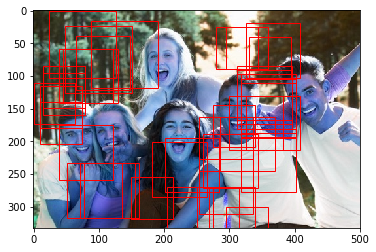

In [25]:
import matplotlib.patches as patches
im = np.array(np.array(image).astype('uint8'))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for i in boxes:
    rect = patches.Rectangle((i['location'][1][0] * (1 +  i['pic_reducing']),
                              i['location'][0][0] * (1 +  i['pic_reducing'])),
                             64*(1 +  i['pic_reducing']),64*(1 +  i['pic_reducing']),
                             linewidth=1,edgecolor='r',facecolor='none')
    # add the boxes to the image
    ax.add_patch(rect)

plt.show()

In [ ]:
threshold = 0.5
remove = list()
for i in range(len(a)):
    for j in range(i+1,len(a)):
        if j not in remove:
            y = abs(a[i]['location'][1][0] - a[j]['location'][1][0])
            x = abs(a[i]['location'][0][0] - a[j]['location'][0][0])
            result = ((x<=64)*(y<=64)*((64 - x) + (64 - y)))/ (64 * 2)
            if result >= threshold:
                remove.append(j)
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
for j,i in enumerate(a):
    if j not in remove:
        rect = patches.Rectangle((i['location'][1][0],i['location'][0][0]),64,64,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
# Add the patch to the Axes


plt.show()

# <a id='yolo'>YOLO V3</a>

In [ ]:
# Set the location and name of the cfg file
cfg_file = '../input/configfiles/yolo_v3.conf'
class_name = '../input/justoneclass/classes'

In [ ]:
from utils import *
class_names = model_v1.load_class_names(class_name)